In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
import time
%matplotlib inline

# 1 - Load Fashion MNIST by Pandas

In [2]:
TRAIN_FILE = '../fashionmnist/fashion-mnist_train.csv'
TEST_FILE = '../fashionmnist/fashion-mnist_test.csv'
train_data = pd.read_csv(TRAIN_FILE)
test_data = pd.read_csv(TEST_FILE)
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_train_all = np.array(train_data.iloc[:, 1:])
print('pixel value max=', np.max(X_train_all))
X_train_all = X_train_all/ 255
m_train_all = X_train_all.shape[0]
num_px = X_train_all.shape[1]
num_class = 10
y_train_all = np.array(train_data.iloc[:, 0], dtype = 'uint8').reshape(-1,1)
print('total number of training examples =', m_train_all, ', number of pixels =', num_px)

pixel value max= 255
total number of training examples = 60000 , number of pixels = 784


In [4]:
#To speed up calculation, only 5000 out of 60000 examples will be used as training set
#Although the original data are already random, still shuffle them for general purpose
m_train = 5000
permutation = list(np.random.permutation(m_train_all))
shuffled_X = X_train_all[permutation, :]
shuffled_y = y_train_all[permutation,:]
X_train = shuffled_X[0:m_train,:].T
y_train = shuffled_y[0:m_train,:].T
print('X_train shape', X_train.shape, 'y_train shape', y_train.shape)
print('number of training examples used:', X_train.shape[1])

X_train shape (784, 5000) y_train shape (1, 5000)
number of training examples used: 5000


In [5]:
X_test = np.array(test_data.iloc[:, 1:])
y_test = np.array(test_data.iloc[:, 0], dtype = 'uint8').reshape(-1,1)
X_test = X_test.T
y_test = y_test.T
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape)

X_test shape: (784, 10000) y_test shape: (1, 10000)


# 2 - Logistic regression

In [6]:
def initialization_zero(dim, num_class):
#OK to initialize W to be a zero matrix in logistic regression
    W = np.zeros((num_class,dim))
    b = np.zeros((num_class,1))
    return W, b

def soft_max(Z):
    # substract Z by max(Z) to avoid numerical blowing up
    # although usually each number of Z shouldn't be too big
    Z -= np.max(Z,axis=0)
    A = np.exp(Z)
    norm_A = np.sum(A, axis = 0, keepdims = True)
    softmax = A/norm_A
    return softmax

def forward_propagation(W, b, lambd, X, y):
    m = X.shape[1]
    Z = np.dot(W, X) + b
    P = soft_max(Z)
    reg = lambd /2/m * np.sum(W*W)
    cost = -1/m * np.sum(np.log(P[y, range(m)]),axis = 1)
    cost += reg
    cost = np.squeeze(cost)
    return cost, P

def backward_propagation(X, y, lambd, P):
    m = X.shape[1]
    dZ = P 
    dZ[y, range(m)] -= 1
    dW = 1/m* np.dot(dZ, X.T)
    dW += lambd/m * W
    db = 1/m * np.sum(dZ, axis=1, keepdims = True)
    return dW,db

def optimize(W, b, X, y, lambd, num_iter, learning_rate):
    costs = []
    for i in range(num_iter):
        cost, P = forward_propagation(W, b, lambd, X, y)
        dW, db = backward_propagation(X, y, lambd, P)
        W = W - learning_rate * dW
        b = b - learning_rate * db
        costs.append(cost)
    return costs, W, b

def predict_accuracy(W, b, X, y):
    Z = np.dot(W, X) + b
    predicted_class = np.argmax(Z, axis=0)
    accuracy = np.mean(predicted_class == y)
    return accuracy

learning rate = 1.0000
train accuracy: 0.7926
test accuracy: 0.7534
elapsed time =  3.9017679691314697
---------------------
learning rate = 0.1000
train accuracy: 0.8238
test accuracy: 0.7953
elapsed time =  3.688735008239746
---------------------
learning rate = 0.0100
train accuracy: 0.7158
test accuracy: 0.7039
elapsed time =  3.5147950649261475
---------------------


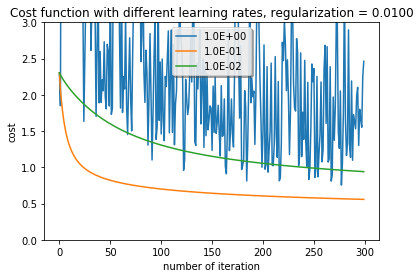

In [7]:
learning_rates = [1, 1e-1, 1e-2]
lambd = 0.01
for rate in learning_rates:
    t = time.time()
    W, b = initialization_zero(num_px, num_class)
    costs, W, b = optimize(W,b, X_train, y_train, lambd, num_iter = 300, learning_rate = rate)
    plt.plot(np.squeeze(costs), label = '%.1E' %rate)

    print('learning rate = %.4f' %rate)
    accuracy = predict_accuracy(W, b, X_train, y_train)
    print('train accuracy: %.4f' %accuracy)
    accuracy = predict_accuracy(W, b, X_test, y_test)
    print('test accuracy: %.4f' %accuracy)
    
    t = time.time()-t
    print('elapsed time = ', t)
    print('---------------------')


plt.ylabel('cost')
plt.xlabel('number of iteration')
plt.title("Cost function with different learning rates, regularization = %.4f" %lambd )
legend = plt.legend(loc='upper center', shadow=True)
axes = plt.gca()
axes.set_ylim([0,3])
plt.show()

# 3 - Benchmark with sklearn build-in library

In [27]:
t = time.time()
clf = linear_model.LogisticRegression(C=1e2, solver = 'lbfgs')
clf.fit(X_train.T, np.ravel(y_train))
score_train = clf.score(X_train.T, np.ravel(y_train))
score_test = clf.score(X_test.T, np.ravel(y_test))
t = time.time()-t
print('sklearn logistic regression train accurary = ', score_train)
print('sklearn logistic regression test accurary = ', score_test)
print('elapsed time = ', t)

sklearn logistic regression train accurary =  0.9636
sklearn logistic regression test accurary =  0.7062
elapsed time =  5.300169944763184


## Comparing code with sklearn build-in logistic regression: learning rate = 0.1 gives better test accuracy 79.5% and timing! Looks great!